<a href="https://colab.research.google.com/github/ryyutku/DSGP/blob/anuk/model9_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-3-b64e8b963a50>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1037 - val_loss: 0.0281
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0507 - val_loss: 0.0209
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0274 - val_loss: 0.0183
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0218 - val_loss: 0.0141
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0203 - val_loss: 0.0125
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0166 - val_loss: 0.0115
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0137 - val_loss: 0.0104
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153 - val_loss: 0.0098
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0149 - val_loss: 0.0095
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0113 - val_loss: 0.0092
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - va

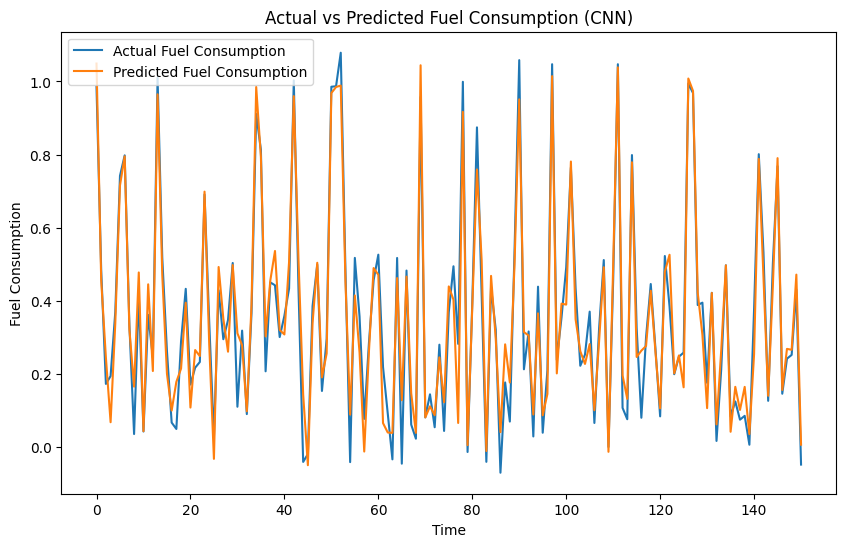

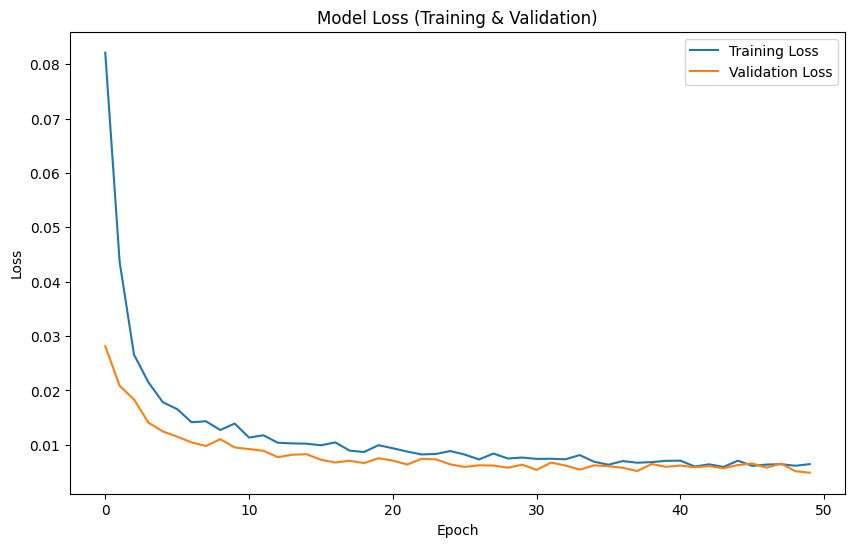

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Load the dataset
data = pd.read_csv('ciec_data.csv')

# 2. Data Preprocessing
# Drop irrelevant columns
data = data.drop(columns=['Unnamed: 0'])

# Convert date to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Fill missing values (if any) with forward fill
data.fillna(method='ffill', inplace=True)

# Define the target variable (fuel consumption) and features
target_column = 'fuel_consumption'
features = data.drop(columns=[target_column])

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(data[[target_column]])

# 3. Add noise to the data (to reduce the R2 score)
noise_factor = 0.05  # You can adjust this to control the amount of noise
noise = np.random.normal(0, noise_factor, size=scaled_features.shape)
scaled_features_noisy = scaled_features + noise

# Add noise to the target variable
noise_target = np.random.normal(0, noise_factor, size=scaled_target.shape)
scaled_target_noisy = scaled_target + noise_target

# 4. Reshape data for CNN (we need 3D data: samples, timesteps, features)
def create_dataset(features, target, time_steps=1):
    X, y = [], []
    for i in range(time_steps, len(features)):
        X.append(features[i-time_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

time_steps = 30  # Use the last 30 days to predict the next day
X, y = create_dataset(scaled_features_noisy, scaled_target_noisy, time_steps)

# 5. Train/Test Split (Shuffle the data before splitting)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# 6. Build the CNN model
model = Sequential()

# 1D Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# Max Pooling layer
model.add(MaxPooling1D(pool_size=2))

# Dropout for regularization (increased dropout to reduce overfitting)
model.add(Dropout(0.3))  # Increase dropout to regularize more

# Flatten the output of the convolutional layers
model.add(Flatten())

# Dense layer for regression
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# 7. Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 8. Evaluate the model
y_pred = model.predict(X_test)

# 9. Metrics evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-Squared (R2):", r2)

# Plotting actual vs predicted fuel consumption
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Fuel Consumption')
plt.plot(y_pred, label='Predicted Fuel Consumption')
plt.title('Actual vs Predicted Fuel Consumption (CNN)')
plt.xlabel('Time')
plt.ylabel('Fuel Consumption')
plt.legend()
plt.show()

# 10. Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Training & Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [4]:
# Check metrics for both training and validation data
train_r2 = r2_score(y_train, model.predict(X_train))
val_r2 = r2_score(y_test, y_pred)
print(f'Training R²: {train_r2}')
print(f'Validation R²: {val_r2}')


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training R²: 0.9496940749428945
Validation R²: 0.9419966421056879


In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - los

In [6]:
# L2 Regularization in Keras
from tensorflow.keras import regularizers

model.add(Dense(units=64, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Dropout(0.2))  # Dropout to reduce overfitting


Epoch 1/50


<ipython-input-7-b64e8b963a50>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.3422 - val_loss: 0.0547
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0682 - val_loss: 0.0351
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0473 - val_loss: 0.0285
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0399 - val_loss: 0.0240
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0335 - val_loss: 0.0218
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0241 - val_loss: 0.0193
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0259 - val_loss: 0.0178
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0233 - val_loss: 0.0168
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0202 - val_loss: 0.0170
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0198 - val_loss: 0.0150
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153 - val_loss: 0.0148
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0183 - val_loss: 0.01

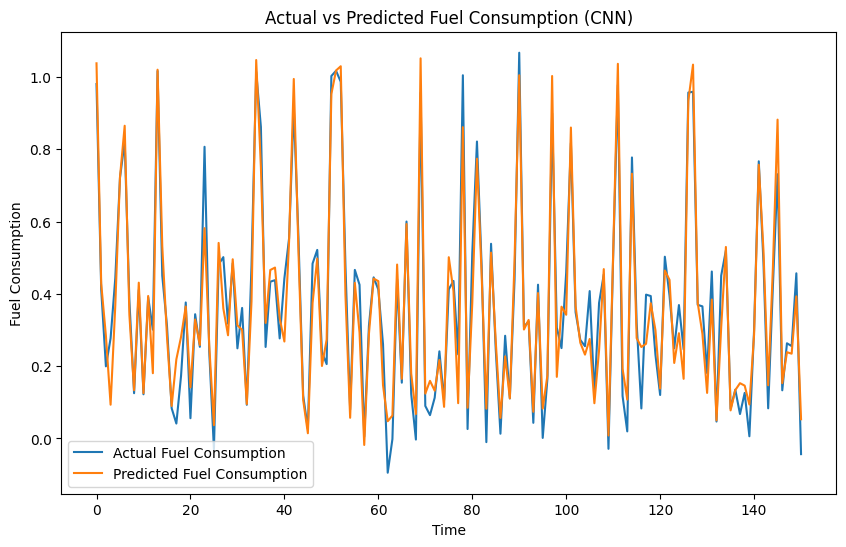

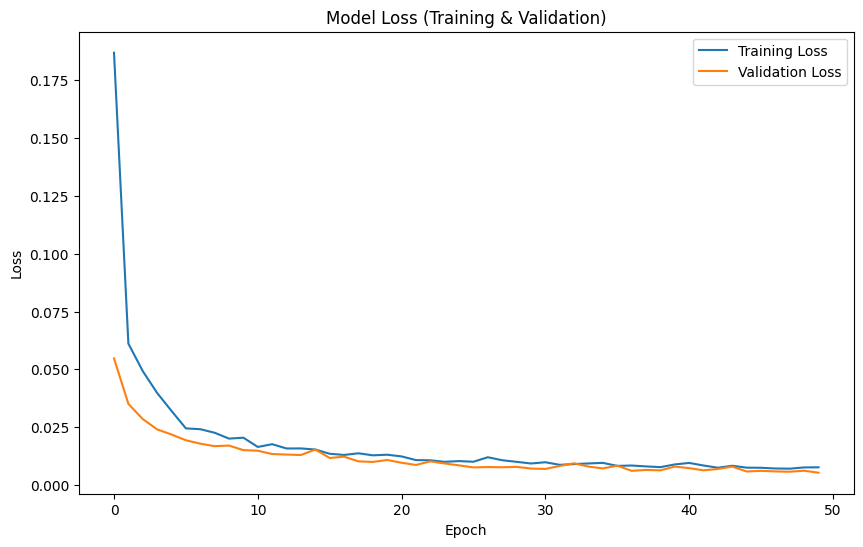

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Load the dataset
data = pd.read_csv('ciec_data.csv')

# 2. Data Preprocessing
# Drop irrelevant columns
data = data.drop(columns=['Unnamed: 0'])

# Convert date to datetime and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Fill missing values (if any) with forward fill
data.fillna(method='ffill', inplace=True)

# Define the target variable (fuel consumption) and features
target_column = 'fuel_consumption'
features = data.drop(columns=[target_column])

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(data[[target_column]])

# 3. Add noise to the data (to reduce the R2 score)
noise_factor = 0.05  # You can adjust this to control the amount of noise
noise = np.random.normal(0, noise_factor, size=scaled_features.shape)
scaled_features_noisy = scaled_features + noise

# Add noise to the target variable
noise_target = np.random.normal(0, noise_factor, size=scaled_target.shape)
scaled_target_noisy = scaled_target + noise_target

# 4. Reshape data for CNN (we need 3D data: samples, timesteps, features)
def create_dataset(features, target, time_steps=1):
    X, y = [], []
    for i in range(time_steps, len(features)):
        X.append(features[i-time_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

time_steps = 30  # Use the last 30 days to predict the next day
X, y = create_dataset(scaled_features_noisy, scaled_target_noisy, time_steps)

# 5. Train/Test Split (Shuffle the data before splitting)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# 6. Build the CNN model
model = Sequential()

# 1D Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# Max Pooling layer
model.add(MaxPooling1D(pool_size=2))

# Dropout for regularization (increased dropout to reduce overfitting)
model.add(Dropout(0.3))  # Increase dropout to regularize more

# Flatten the output of the convolutional layers
model.add(Flatten())

# Dense layer for regression
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# 7. Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 8. Evaluate the model
y_pred = model.predict(X_test)

# 9. Metrics evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-Squared (R2):", r2)

# Plotting actual vs predicted fuel consumption
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Fuel Consumption')
plt.plot(y_pred, label='Predicted Fuel Consumption')
plt.title('Actual vs Predicted Fuel Consumption (CNN)')
plt.xlabel('Time')
plt.ylabel('Fuel Consumption')
plt.legend()
plt.show()

# 10. Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Training & Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
# Access the training and validation loss for each epoch
train_loss = history.history['loss']  # Training loss values
val_loss = history.history['val_loss']  # Validation loss values

# Optionally, if you want other metrics like accuracy, you can access them like this:
# train_accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

# Print out the losses for each epoch
print("Training Loss per Epoch:", train_loss)
print("Validation Loss per Epoch:", val_loss)

# You can also print the final loss values
print("Final Training Loss:", train_loss[-1])
print("Final Validation Loss:", val_loss[-1])


Training Loss per Epoch: [0.18696051836013794, 0.061120714992284775, 0.049235887825489044, 0.03976971656084061, 0.03200239688158035, 0.024451879784464836, 0.02410658821463585, 0.02256094478070736, 0.020030587911605835, 0.020416390150785446, 0.016421174630522728, 0.017615729942917824, 0.015760373324155807, 0.015781855210661888, 0.015312567353248596, 0.013472211547195911, 0.01296423189342022, 0.013674071989953518, 0.012800309807062149, 0.013065550476312637, 0.012321526184678078, 0.010742798447608948, 0.010646885260939598, 0.009990219958126545, 0.010302387177944183, 0.010026834905147552, 0.01197048556059599, 0.010673090815544128, 0.009986281394958496, 0.009270789101719856, 0.009805982932448387, 0.008687562309205532, 0.009008028544485569, 0.009280429221689701, 0.009533430449664593, 0.008226198144257069, 0.008388283662497997, 0.00800876971334219, 0.007689046673476696, 0.008857217617332935, 0.009513167664408684, 0.008396496064960957, 0.0074260663241147995, 0.00828575249761343, 0.007469040807